#Recommendation of Product on the basis of Feature Extracted from the product details and the co-purchases made

##1. Data Extraction from unstructured text dataset into structured dataframe

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import re
from pprint import pprint
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity

### 1.1 Creating dataframe from meta dataset of products by iterating through text-file

In [5]:
filepath = '/content/drive/MyDrive/BAJAJ/GNN_datasets/amazon-meta.txt'
text = open(filepath, 'r', encoding = 'utf-8')

In [6]:
Ids = []
ASINs = []
titles =[]
salesranks = []
similars = []
num_categories = []
groups = []
categories = []
reviews = []
reviewinfo = []
lc = 0
for line in text:
    lastcat = False
    lastrev = False
    categoies =[]
    lineelements = line.split(':')
    lineelements = [x.strip() for x in lineelements]
    if 'Id' == lineelements[0]:
        Ids.append(lineelements[1])
    elif 'ASIN' == lineelements[0]:
        ASINs.append(lineelements[1])
    elif 'discontinued product' in lineelements:
        Ids.pop(-1)
        ASINs.pop(-1)
    elif 'title' == lineelements[0]:
        titles.append(''.join(lineelements[1]))
    elif 'group' == lineelements[0]:
        groups.append(lineelements[1])
    elif 'salesrank' == lineelements[0]:
        salesranks.append(lineelements[1])
    elif 'similar' == lineelements[0]:
        lineelements.pop(0)
        element = ' '.join(lineelements)
        similars.append(element)
        
    elif 'categories' == lineelements[0]:
        num_categories.append(lineelements[1])
        lastcat = True
        cats = []
        cnt = 0
        for i in range(int(lineelements[1])):
            l = text.readline()
            cats.append('|'.join(l.split('|')[2:]).strip())
        categories.append(cats)
    elif 'reviews' == lineelements[0]:
        review = ':'.join(lineelements[1:]).strip()
        reviews.append(review)
        sub = review.split()
        subsub = [x.split(':') for x in sub]
        r = []
        for i in range(int(subsub[1][1])):
            l = text.readline()
            r.append(l)
        reviewinfo.append(r)

In [7]:
data = {'ID':Ids, 
        'ASIN':ASINs, 
        'title':titles, 
        'group':groups, 
        'salesrank':salesranks, 
        'similar':similars, 
        'num_categories':num_categories, 
        'categories':categories,
        'review':reviews, 
        'reviewinfo':reviewinfo}

In [8]:
df = pd.DataFrame(data)

In [9]:
df.head()

,ID,ASIN,title,group,salesrank,similar,num_categories,categories,review,reviewinfo
0,1,0827229534,Patterns of Preaching,Book,396585,5 0804215715 156101074X 0687023955 0687074...,2,[Subjects[1000]|Religion & Spirituality[22]|Ch...,total:2 downloaded:2 avg rating:5,[ 2000-7-28 cutomer: A2JW67OY8U6HHK ratin...
1,2,0738700797,Candlemas,Book,168596,5 0738700827 1567184960 1567182836 0738700...,2,[Subjects[1000]|Religion & Spirituality[22]|Ea...,total:12 downloaded:12 avg rating:4.5,[ 2001-12-16 cutomer: A11NCO6YTE4BTJ rati...
2,3,0486287785,World War II Allied Fighter Planes Trading Cards,Book,1270652,0,1,[Subjects[1000]|Home & Garden[48]|Crafts & Hob...,total:1 downloaded:1 avg rating:5,[ 2003-7-10 cutomer: A3IDGASRQAW8B2 ratin...
3,4,0842328327,Life Application Bible Commentary,Book,631289,5 0842328130 0830818138 0842330313 0842328...,5,[Subjects[1000]|Religion & Spirituality[22]|Ch...,total:1 downloaded:1 avg rating:4,[ 2004-8-19 cutomer: A2591BUPXCS705 ratin...
4,5,1577943082,Prayers That Avail Much for Business,Book,455160,5 157794349X 0892749504 1577941829 0892749...,2,[Subjects[1000]|Religion & Spirituality[22]|Ch...,total:0 downloaded:0 avg rating:0,[]


####Saving features extracted from the dataset for future use-cases

In [10]:
df.to_csv('/content/drive/MyDrive/BAJAJ/GNN_datasets/extracteddata.csv')

### 1.2. Feature Extraction and Dataset Creation 

In [11]:
%%bash
!pip install fsspec
pip install dask[dataframe]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


bash: line 1: !pip: command not found


In [12]:
import dask.dataframe as dd

##### Helper Functions

In [13]:
def extractrating(x):
    reviewsplit = x['review'].split()
    y = float(reviewsplit[3].split(':')[1])
    return y

In [14]:
def extractdownloads(x):
    reviewsplit = x['review'].split()
    num = int(reviewsplit[1].split(':')[1])
    return num

In [15]:
def extracttotal(x):
    reviewsplit = x['review'].split()
    num = int(reviewsplit[0].split(':')[1])
    return num

In [16]:
df = dd.read_csv('/content/drive/MyDrive/BAJAJ/GNN_datasets/extracteddata.csv').set_index('Unnamed: 0')

#### Using Dask for handling large scale data pre-processing using capabilities of parallel processing

In [17]:
df1 = df.copy()
df1['totalreviews'] = df1.apply(extracttotal, axis =1, meta = ('totalreviews', 'i8'))
df1['downloadedreviews'] = df1.apply(extractdownloads, axis = 1, meta = ('downloadedreviews', 'i8'))
df1['avg_rating'] = df1.apply(extractrating, axis = 1, meta = ('avg_rating', 'i8'))
df1 = df1.drop('review', axis = 1)
df1 = df1.reset_index().drop('Unnamed: 0', axis = 1)
df1.ID = df1.ID.astype('int64')
df1.salesrank = df1.salesrank.astype('int64')
df1.num_categories = df1.num_categories.astype('int64')
df1.head()

,ID,ASIN,title,group,salesrank,similar,num_categories,categories,reviewinfo,totalreviews,downloadedreviews,avg_rating
0,1,0827229534,Patterns of Preaching,Book,396585,5 0804215715 156101074X 0687023955 0687074...,2,['Subjects[1000]|Religion & Spirituality[22]|C...,[' 2000-7-28 cutomer: A2JW67OY8U6HHK rati...,2,2,5.0
1,2,0738700797,Candlemas,Book,168596,5 0738700827 1567184960 1567182836 0738700...,2,['Subjects[1000]|Religion & Spirituality[22]|E...,[' 2001-12-16 cutomer: A11NCO6YTE4BTJ rat...,12,12,4.5
2,3,0486287785,World War II Allied Fighter Planes Trading Cards,Book,1270652,0,1,['Subjects[1000]|Home & Garden[48]|Crafts & Ho...,[' 2003-7-10 cutomer: A3IDGASRQAW8B2 rati...,1,1,5.0
3,4,0842328327,Life Application Bible Commentary,Book,631289,5 0842328130 0830818138 0842330313 0842328...,5,['Subjects[1000]|Religion & Spirituality[22]|C...,[' 2004-8-19 cutomer: A2591BUPXCS705 rati...,1,1,4.0
4,5,1577943082,Prayers That Avail Much for Business,Book,455160,5 157794349X 0892749504 1577941829 0892749...,2,['Subjects[1000]|Religion & Spirituality[22]|C...,[],0,0,0.0


#### Extracting Review Information identified by product Id

In [18]:
df2 = df1[['ID', 'reviewinfo']].copy()
df2.reviewinfo = df2.reviewinfo.str.strip('][').str.replace("'", '').str.split(',')
df2 = df2.explode('reviewinfo').reset_index()
df2 = df2.drop(['index'], axis = 1)
df1 = df1.drop('reviewinfo', axis = 1)
df2.head()

,ID,reviewinfo
0,1,2000-7-28 cutomer: A2JW67OY8U6HHK rating...
1,1,2003-12-14 cutomer: A2VE83MZF98ITY rati...
2,2,2001-12-16 cutomer: A11NCO6YTE4BTJ ratin...
3,2,2002-1-7 cutomer: A9CQ3PLRNIR83 rating...
4,2,2002-1-24 cutomer: A13SG9ACZ9O5IM ratin...


#### Extracting Categories Information identified by product Id

In [19]:
df3 = df1[['ID', 'categories']].copy()
df3['categories'] = df3.categories.str.strip('][').str.replace("'", '').str.split(',')
df3 = df3.explode('categories').reset_index()
df3 = df3.drop('index', axis = 1)
df1 = df1.drop(['categories'], axis = 1)
df3.head()

,ID,categories
0,1,Subjects[1000]|Religion & Spirituality[22]|Chr...
1,1,Subjects[1000]|Religion & Spirituality[22]|Ch...
2,2,Subjects[1000]|Religion & Spirituality[22]|Ear...
3,2,Subjects[1000]|Religion & Spirituality[22]|Ea...
4,3,Subjects[1000]|Home & Garden[48]|Crafts & Hobb...


#### Extracting Similar Products Information identified by product Id

In [20]:
df4 = df1[['ID', 'similar']].copy()
df4.similar = df4.similar.str.split()
df4 = df4.reset_index().drop('index', axis =1)
df1 = df1.drop('similar', axis = 1)
df4.head()

,ID,similar
0,1,"[5, 0804215715, 156101074X, 0687023955, 068707..."
1,2,"[5, 0738700827, 1567184960, 1567182836, 073870..."
2,3,[0]
3,4,"[5, 0842328130, 0830818138, 0842330313, 084232..."
4,5,"[5, 157794349X, 0892749504, 1577941829, 089274..."


#### Saving Dataframes for further analysis

In [21]:
df1.compute().to_csv('/content/drive/MyDrive/finalpreprocesseddata.csv', index = False)
df2.compute().to_csv('/content/drive/MyDrive/reviews.csv', index = False)
df3.compute().to_csv('/content/drive/MyDrive/categories.csv', index = False)
df4.compute().to_csv('/content/drive/MyDrive/similar.csv', index = False)

## 2.Implementing a recommendation System based on the extracted features using Similarity Measures

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Creating a Directed graph from the given edgelist

In [25]:
Graphtype = nx.DiGraph()
filepath = 'drive/MyDrive/BAJAJ/GNN_datasets/amazon0601.txt'
G = nx.read_edgelist(
    filepath,
    comments='#',
    create_using=Graphtype,
    nodetype=int
)

#### Reading Metadata

In [26]:
df = pd.read_csv('drive/MyDrive/BAJAJ/GNN_datasets/finalpreprocesseddata.csv')

In [27]:
df.head()

,ID,ASIN,title,group,salesrank,num_categories,totalreviews,downloadedreviews,avg_rating
0,1,0827229534,Patterns of Preaching,Book,396585,2,2,2,5.0
1,2,0738700797,Candlemas,Book,168596,2,12,12,4.5
2,3,0486287785,World War II Allied Fighter Planes Trading Cards,Book,1270652,1,1,1,5.0
3,4,0842328327,Life Application Bible Commentary,Book,631289,5,1,1,4.0
4,5,1577943082,Prayers That Avail Much for Business,Book,455160,2,0,0,0.0


##### Checking and Dropping Null Values

In [28]:
df.isnull().sum()
df = df.dropna()

ID                   0
ASIN                 0
title                2
group                0
salesrank            0
num_categories       0
totalreviews         0
downloadedreviews    0
avg_rating           0
dtype: int64

In [31]:
df['group'].value_counts()

Book            393559
Music           103144
Video            26131
DVD              19828
Toy                  8
Software             5
CE                   4
Video Games          1
Baby Product         1
Sports               1
Name: group, dtype: int64

#####Indexing the graph on the attribute 'ID'

In [33]:
df = df.set_index('ID')

#### Selecting Attributes that each nodes will have 

In [35]:
nodeattrdf = df[['ASIN','title','group', 'num_categories','salesrank', 'totalreviews', 'downloadedreviews', 'avg_rating']].copy()

#### Combining the transaction data and the metadata into a networkX Directed Graph

In [36]:
nx.set_node_attributes(G, nodeattrdf.to_dict('index'))

In [37]:
G.nodes[8]

{'ASIN': '0231118597',
 'avg_rating': 4.5,
 'downloadedreviews': 15,
 'group': 'Book',
 'num_categories': 4,
 'salesrank': 277409,
 'title': 'Losing Matt Shepard',
 'totalreviews': 15}

####**Empty nodes/Disjoint nodes do not contribute significantly when we recommended products.So we have removed them**

In [38]:

remove = [nodes for nodes in dict(G.nodes()) if len(G.nodes[nodes]) == 0]

In [39]:
G.remove_nodes_from(remove)

Here, n is the array of all non-deleted nodes in the graph

In [41]:
n = list(G.nodes)

In [42]:
n =  np.array(n)
n = np.unique(n)

##### Helper function to retrive all target nodes from the edges starting from the source

In [44]:
def getclean(pro_id):    
    l = str(list(G.edges(pro_id)))
    l = l.replace('[','')
    l = l.replace(']','')
    l = l.replace(',','')
    l = l.replace('(','')
    l = l.replace(')','')
    l = l.replace(str(pro_id)+" ", '')
    b = l.split()
    b = np.array(b)
    b = b.astype(int)
    return b

In [45]:
G.edges(5)

OutEdgeDataView([(5, 6), (5, 44), (5, 46), (5, 47), (5, 48), (5, 49), (5, 50), (5, 51), (5, 52), (5, 53)])

In [46]:
getclean(5)

array([ 6, 44, 46, 47, 48, 49, 50, 51, 52, 53])

####Function for user to search for a product

In [47]:
def search(s):
  s = s.lower()
  indx = df.index[(df['title'].str.contains(s, case = False))==True]   
  indx = np.array(indx)
  indx = indx.astype(int)
  return indx

Storing array of indexes in an array

In [48]:
iarray = search(str(input()))
print(len(iarray))

for i in range(0, len(iarray)):
  if(iarray[i] in n):
    print(iarray[i], G.nodes[iarray[i]]['title'])

8


##### Input the product id of the product bought by user

In [51]:
tempinput = int(input())
if(tempinput in n):
  pro_id = tempinput
  print("Selected product is", pro_id)
else:
  print("Empty node has been removed from the graph!")

56
Selected product is 56


#####Final result denotes all the connected edges to the source(source is product selected)

In [52]:
finalresult = []
resultarray = np.unique(getclean(pro_id))
for i in range(1, len(resultarray)):
    if(resultarray[i] in n):
        finalresult.append(resultarray[i])

print(len(finalresult))

#####Helper function to display titles

In [54]:
def showtitles(array):
    titles = []
    for i in range(len(array)):
        titles.append(G.nodes[array[i]]['title'])
    return titles

##### Helper function to display ASIN numbers

In [55]:
def showasin(array):
    asins = []
    for i in range(len(array)):
        asins.append(G.nodes[array[i]]['ASIN'])
    asins = np.array(asins)
    #asins = asins.astype(int)
    return asins

In [56]:
t = showtitles(finalresult)
print(G.nodes[pro_id]['title'],"\n\n\n", t)

Three Bricks Shy of a Load 


 ['How the Other Half Lives', 'How to Kill a Monster (Goosebumps)', 'Investigating Computer Crime', 'Black Friday (Soul Survivor Series, Bk. 4)', 'Capital', 'Ten Black Dots', 'Cocktail Hour', 'You Can Name 100 Dinosaurs!', 'Dink the Little Dinosaur']


##### Helper Function to retrive a subset of the dictionary(i.e the features we are concerned with)

In [57]:
def getsubdict(d):
    required_keys = ('group' ,'num_categories', 'totalreviews', 'downloadedreviews', 'avg_rating')
    subdict = {x: d[x] for x in required_keys if x in d}
    return subdict
    

**NOTE**

Here, our initial approach was to calculate Correlation and Cosine similarities between the features of the two nodes to determine the "weight", or how similar they were. 
However, that approach was erroneous. Correlation implies that a product with high salesrank will be highly correlated with a product with high salesrank. But, Low salesrank is desirable. 

Hence, we moved to a new metric - Jaccard Index. 

In [72]:
# def gethighestcorr(pro_id, finalresult, metric):  
#     corrdict = {}
#     cosdict = {}   
#     selarray = np.array(list(getsubdict(G.nodes[pro_id]).values()))
#     selarray = selarray.astype(float)
#     for i in range(1,len(finalresult)):
#         comparray = np.array(list(getsubdict(G.nodes[finalresult[i]]).values()))
#         comparray = comparray.astype(float)        
#         if(pro_id != i):
#             cosineval = cosine_similarity([selarray], [comparray])[0][0]
#             cosdict[finalresult[i]] = cosineval
#             corr = np.corrcoef(selarray, comparray)[0][1]
#             corrdict[finalresult[i]] = corr               
#     corrdict = dict(sorted(corrdict.items(), key=lambda item: item[1], reverse = True))
#     cosdict = dict(sorted(cosdict.items(), key=lambda item: item[1], reverse = True))
#     print(corrdict, cosdict)
#     if(metric == 'corr'):
#       return corrdict
#     elif(metric == 'cosine'):
#       return cosdict
# metric = input()
# finaldict = gethighestcorr(pro_id, finalresult, metric)
# len(finaldict)
# top5 = np.array(list(finaldict.keys()))[:5]
# top5
# showtitles(top5)
# showasin(top5)
# arr1 = np.append(top5, pro_id)
# finalresult = np.array(finalresult)
# diff = np.setdiff1d(finalresult, top5)
# arr2 = np.append(diff,pro_id)
# H = G.subgraph(arr1)
# L = G.subgraph(arr2)
# fig = plt.figure(1, figsize=(20, 10), dpi= 200)
# nx.draw_networkx(H, with_labels = True, edge_color = 'r')
# nx.draw_networkx(L, with_labels = True)
# print(pro_id)
# print(finalresult)
# print(top5)
# type(top5)
#Saving the graph locally to implement efficiently in API
#nx.write_gpickle(G,'drive/MyDrive/BAJAJ/GNN_datasets/G.gpickle')

#### **Jaccard index is a metric that is a a function of number of nodes, not node attributes. Hence, it serves out purpose.**

The Jaccard Index, also known as the Jaccard similarity coefficient, is a statistic used in understanding the similarities between sample sets. The measurement emphasizes similarity between finite sample sets, and is formally defined as the size of the intersection divided by the size of the union of the sample sets. The mathematical representation of the index is written as:

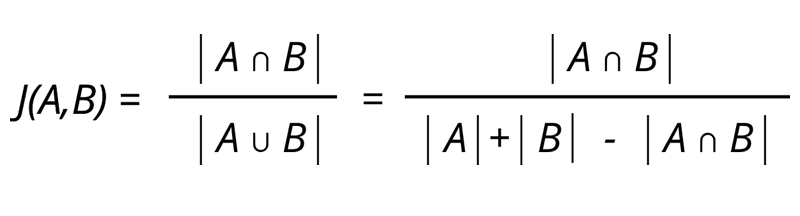

In [73]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

#####Helper function to calculate jaccard index values

In [74]:
def gethighestjaccard(pro_id, finalresult):
  jaccdict = {}    
  for i in range(0,len(finalresult)):     
    if(pro_id != i):      
      tempneighbours = []
      resarray = getclean(finalresult[i])        
      jaccdict[finalresult[i]] = jaccard_similarity(finalresult, resarray)
  return jaccdict    
        

Sorting the Final Dictionary based on Jaccard Indexes

In [75]:
finaldictjaccard = gethighestjaccard(pro_id, finalresult)
finaldictjaccard = dict(sorted(finaldictjaccard.items(), key=lambda item: item[1], reverse = True))

In [77]:
finaldictjaccard

{6: 0.0,
 47: 0.05555555555555555,
 57: 0.058823529411764705,
 119: 0.26666666666666666,
 120: 0.26666666666666666,
 121: 0.05555555555555555,
 122: 0.1875,
 123: 0.11764705882352941,
 124: 0.0}

In [78]:
top5jac = np.array(list(finaldictjaccard.keys()))[:5]

In [79]:
top5jac

array([119, 120, 122, 123,  57])

#### Top 5 Recommendations Made

In [81]:
showtitles(top5jac)

['Black Friday (Soul Survivor Series, Bk. 4)',
 'Capital',
 'Cocktail Hour',
 'You Can Name 100 Dinosaurs!',
 'Investigating Computer Crime']

#### Assigning red edges for recommended products, and blue edges for non-recommended products

In [82]:
K = nx.DiGraph()
for i in top5jac:
  K.add_edge(pro_id,i,color='r')
difjac = np.setdiff1d(finalresult, top5jac)
for i in difjac:
  K.add_edge(pro_id,i,color='b')

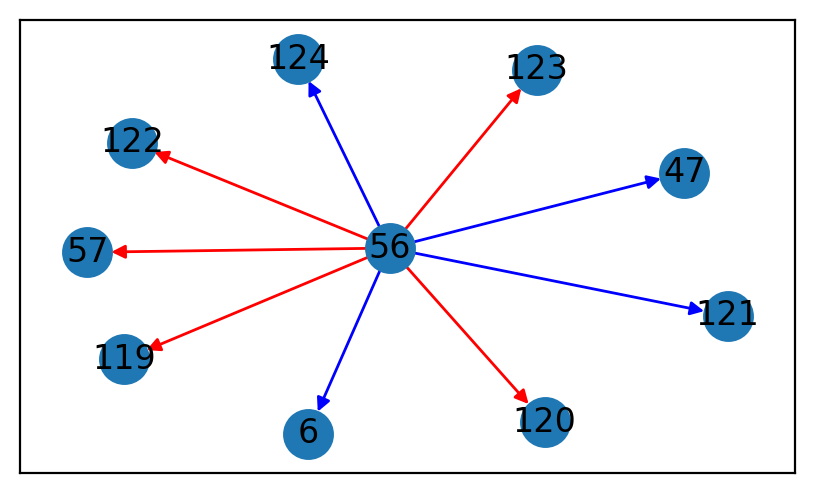

In [83]:
fig = plt.figure(1, figsize=(5, 3), dpi= 200)
colors = nx.get_edge_attributes(K,'color').values()
nx.draw_networkx(K,with_labels = True, edge_color=colors)